<a href="https://colab.research.google.com/github/sahrulromadi/ekg-arrythmia-frequencies-noise-removal/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
import re





signals = pd.read_csv("/content/mitbih_100_signals.csv")
nstdb = pd.read_csv("/content/nstdb.csv")

In [42]:
signals.head()

,MLII,V5,Time
0,-0.145,-0.065,0.000000
1,-0.145,-0.065,0.002778
2,-0.145,-0.065,0.005556
3,-0.145,-0.065,0.008333
4,-0.145,-0.065,0.011111


In [43]:
signals.tail()

,MLII,V5,Time
572742,-0.390,-0.070,1590.950000
572743,-0.380,-0.080,1590.952778
572744,-0.375,-0.080,1590.955556
572745,-0.390,-0.090,1590.958333
572746,-0.400,-0.095,1590.961111


In [44]:
signals.sample(4)

,MLII,V5,Time
351440,-0.260,-0.165,976.222222
563405,-0.470,-0.250,1565.013889
151682,-0.390,-0.315,421.338889
283794,-0.215,-0.165,788.316667


In [45]:
signals.duplicated().sum()

np.int64(0)

In [46]:
missing_values = signals.isnull().sum()
print(missing_values)

MLII    0
V5      0
Time    0
dtype: int64


In [47]:
signals.head()

,MLII,V5,Time
0,-0.145,-0.065,0.000000
1,-0.145,-0.065,0.002778
2,-0.145,-0.065,0.005556
3,-0.145,-0.065,0.008333
4,-0.145,-0.065,0.011111


In [48]:
for i in signals.columns :
    Max = signals[i].max()
    Min = signals[i].min()
    print(i, ":")
    print("the Max :" , Max)
    print("The Min : ", Min)
    print("*********************************")

MLII :
the Max : 1.435
The Min :  -2.715
*********************************
V5 :
the Max : 1.225
The Min :  -2.465
*********************************
Time :
the Max : 1590.961111111111
The Min :  0.0
*********************************


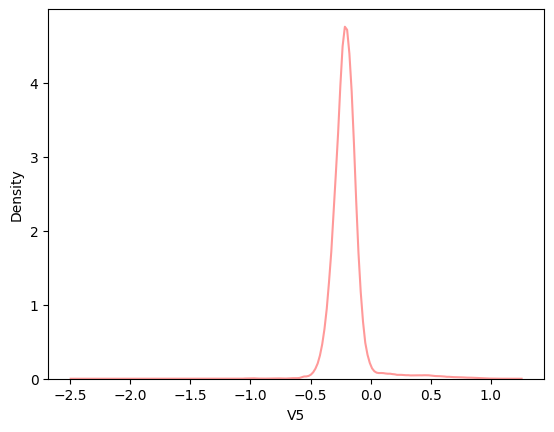

In [49]:
sns.kdeplot(signals['V5'], fill=False, color='r', alpha=0.4)

plt.show()

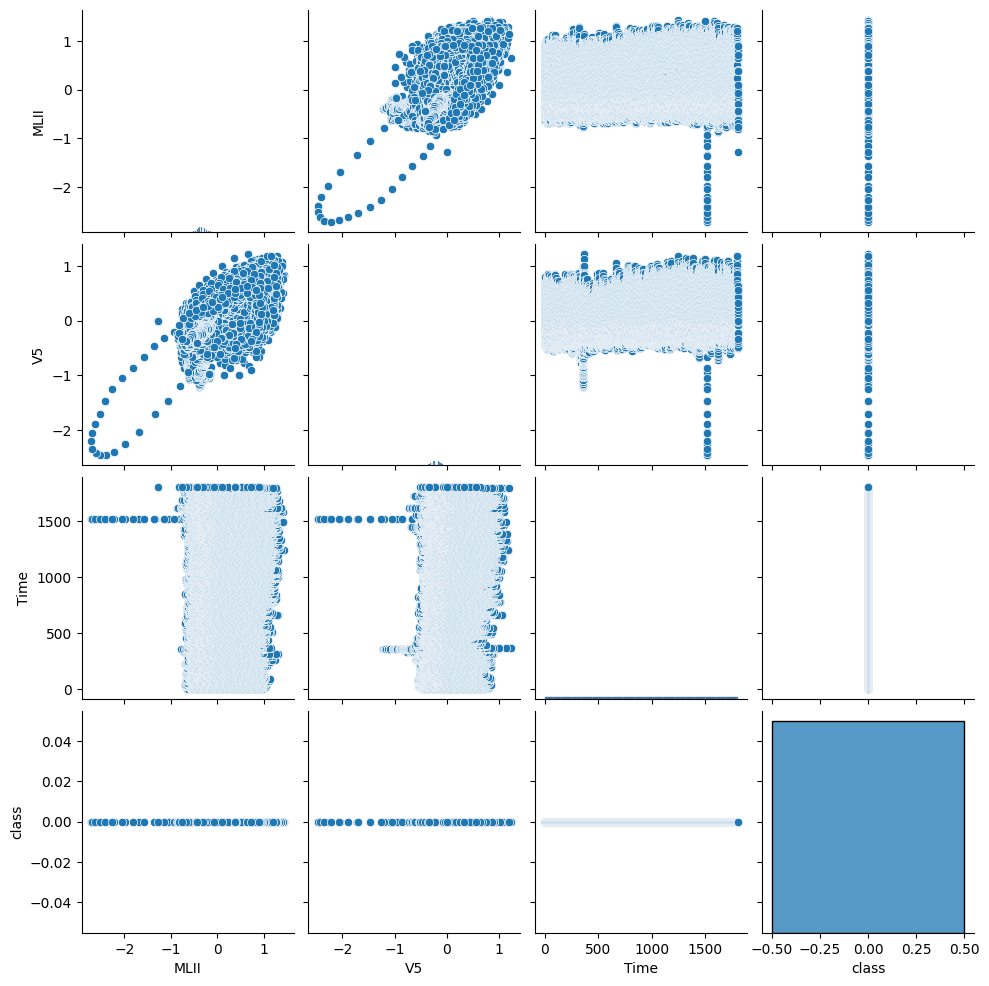

In [15]:
sns.pairplot(signals)

plt.show()

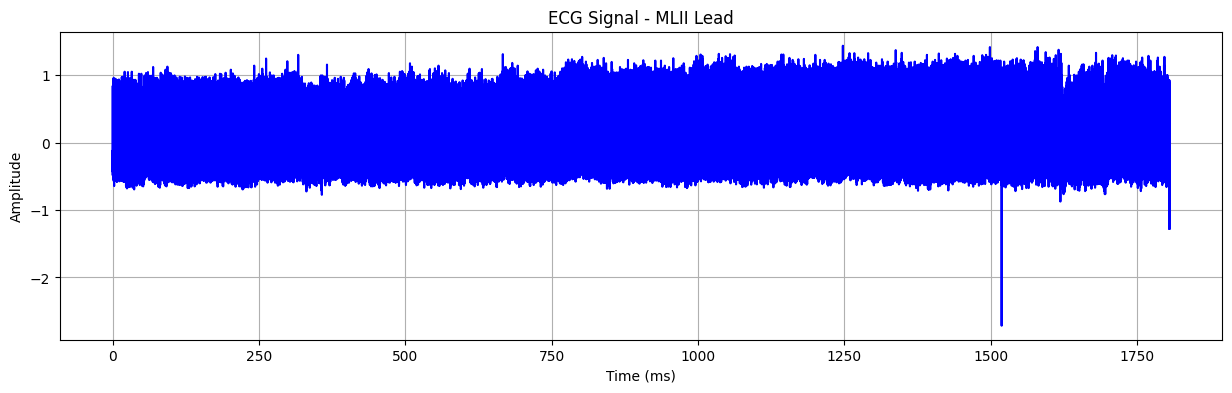

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(signals['Time'], signals['MLII'], color='blue')
plt.title("ECG Signal - MLII Lead")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [19]:
signals.head()

,MLII,V5,Time,class
0,-0.145,-0.065,0.000000,0
1,-0.145,-0.065,0.002778,0
2,-0.145,-0.065,0.005556,0
3,-0.145,-0.065,0.008333,0
4,-0.145,-0.065,0.011111,0


In [20]:
nstdb.head()

,noise1,noise2,Time (s),type
0,0.025,-0.105,0.000000,em
1,0.025,-0.115,0.002778,em
2,0.020,-0.125,0.005556,em
3,0.010,-0.130,0.008333,em
4,0.005,-0.130,0.011111,em


In [21]:
nstdb.tail()

,noise1,noise2,Time (s),type
1949995,-0.865,0.190,1805.541667,bw
1949996,-0.865,0.180,1805.544444,bw
1949997,-0.870,0.175,1805.547222,bw
1949998,-0.860,0.170,1805.550000,bw
1949999,-0.860,0.170,1805.552778,bw


In [23]:
nstdb.duplicated().sum()

np.int64(0)

In [34]:
missing_values = nstdb.isnull().sum()
print(missing_values)

noise1      0
noise2      0
Time (s)    0
type        0
dtype: int64


In [25]:
nstdb.head()

,noise1,noise2,Time (s),type
0,0.025,-0.105,0.000000,em
1,0.025,-0.115,0.002778,em
2,0.020,-0.125,0.005556,em
3,0.010,-0.130,0.008333,em
4,0.005,-0.130,0.011111,em


In [26]:
# Helper to clean signal data
def to_float_array(series, limit=3600):
    vals = []
    for v in series.astype(str).values[:limit]:
        try:
            f = float(v.strip())
            if np.isfinite(f):
                vals.append(f)
        except:
            continue
    return np.array(vals, dtype=np.float64)



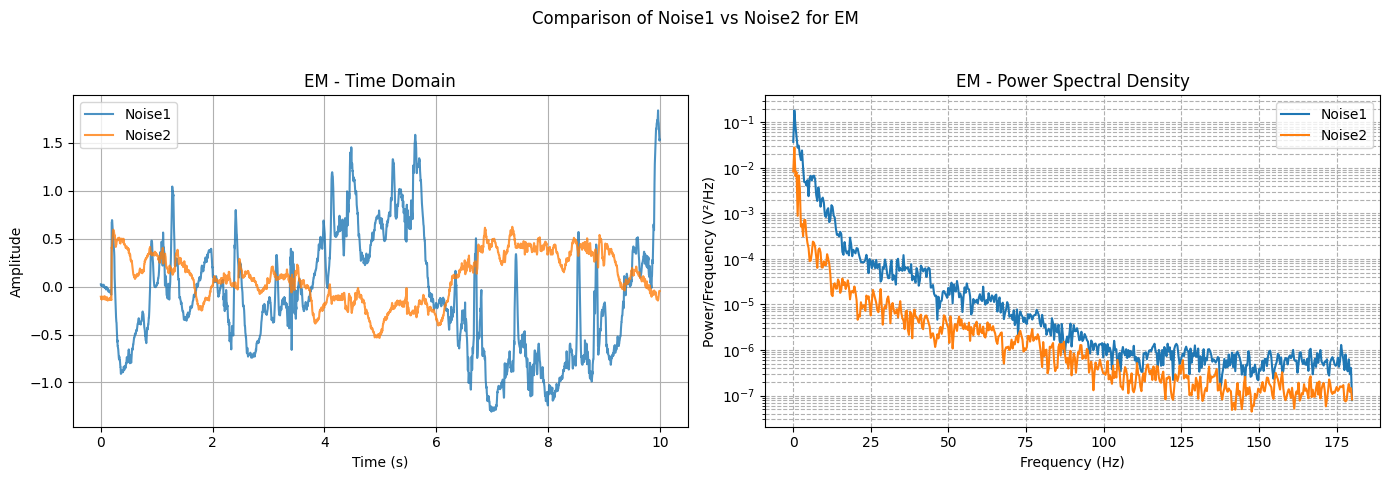

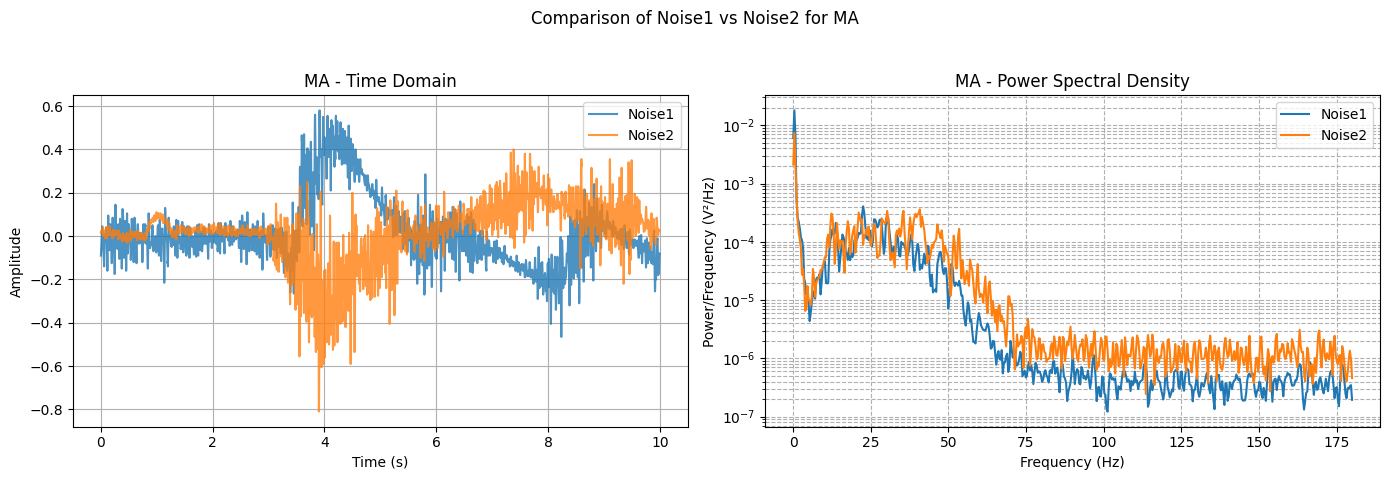

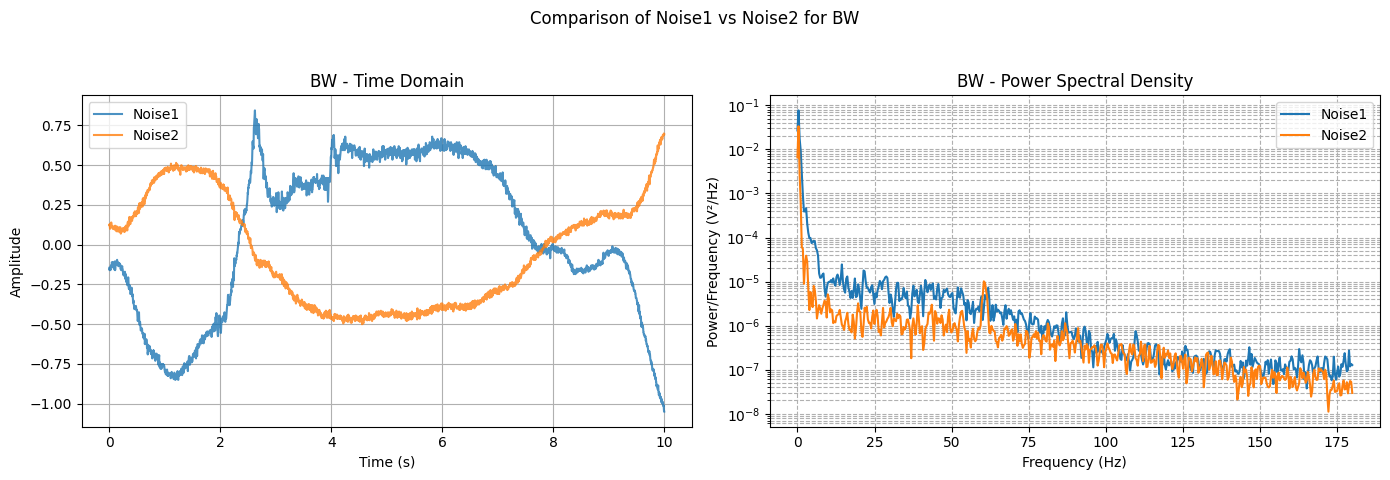

In [29]:
# subset of samples (3600 ~ 10s at 360Hz)
n_samples = 3600
fs = 360


comparisons = {}


for noise_type in ['em', 'ma', 'bw']:
    subset = nstdb[nstdb["type"] == noise_type]
    time_vals = to_float_array(subset["Time (s)"], limit=n_samples)
    noise1 = to_float_array(subset["noise1"], limit=n_samples)
    noise2 = to_float_array(subset["noise2"], limit=n_samples)

    freqs1, psd1 = welch(noise1, fs=fs, nperseg=1024)
    freqs2, psd2 = welch(noise2, fs=fs, nperseg=1024)

    comparisons[noise_type] = {
        "time": time_vals,
        "noise1": noise1,
        "noise2": noise2,
        "freqs1": freqs1,
        "psd1": psd1,
        "freqs2": freqs2,
        "psd2": psd2,
    }


for noise_type, data in comparisons.items():
    plt.figure(figsize=(14, 5))


    plt.subplot(1, 2, 1)
    plt.plot(data["time"], data["noise1"], label="Noise1", alpha=0.8)
    plt.plot(data["time"], data["noise2"], label="Noise2", alpha=0.8)
    plt.title(f"{noise_type.upper()} - Time Domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.semilogy(data["freqs1"], data["psd1"], label="Noise1")
    plt.semilogy(data["freqs2"], data["psd2"], label="Noise2")
    plt.title(f"{noise_type.upper()} - Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (V²/Hz)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

    plt.suptitle(f"Comparison of Noise1 vs Noise2 for {noise_type.upper()}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


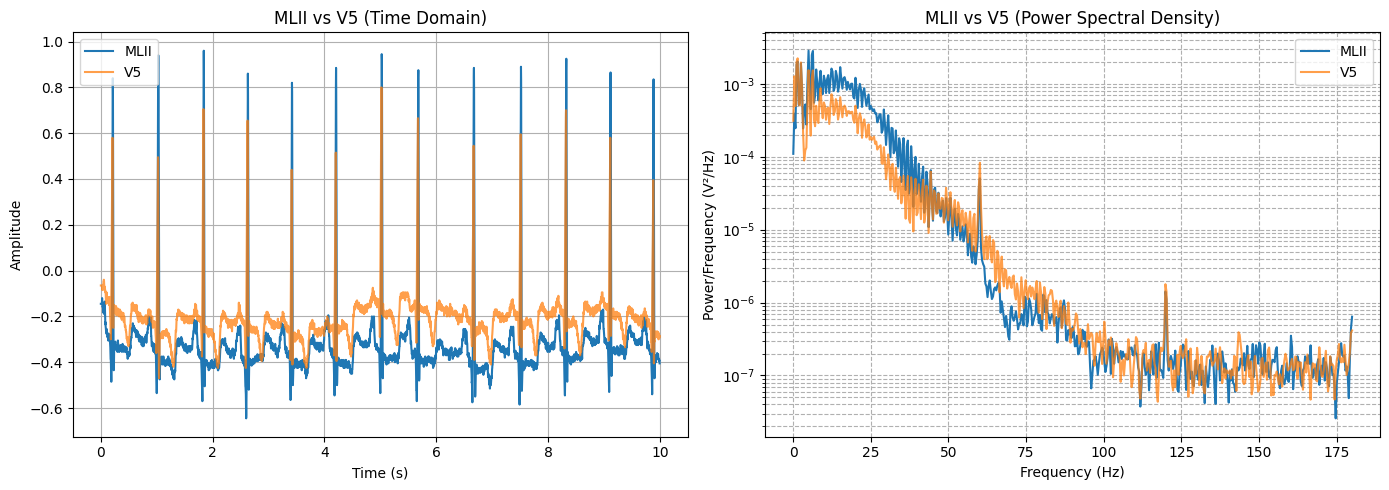

In [30]:
# Limit to first 3600 samples (~10 seconds at 360Hz)
n_samples = 3600
fs = 360

# Extract MLII and V5 channels
ml_ii = signals["MLII"].astype(float).values[:n_samples]
v5 = signals["V5"].astype(float).values[:n_samples]
time_axis = np.arange(n_samples) / fs


freqs_ml, psd_ml = welch(ml_ii, fs=fs, nperseg=1024)
freqs_v5, psd_v5 = welch(v5, fs=fs, nperseg=1024)


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(time_axis, ml_ii, label="MLII")
plt.plot(time_axis, v5, label="V5", alpha=0.75)
plt.title("MLII vs V5 (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.semilogy(freqs_ml, psd_ml, label="MLII")
plt.semilogy(freqs_v5, psd_v5, label="V5", alpha=0.75)
plt.title("MLII vs V5 (Power Spectral Density)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (V²/Hz)")
plt.legend()
plt.grid(True, which="both", linestyle="--")

plt.tight_layout()
plt.show()

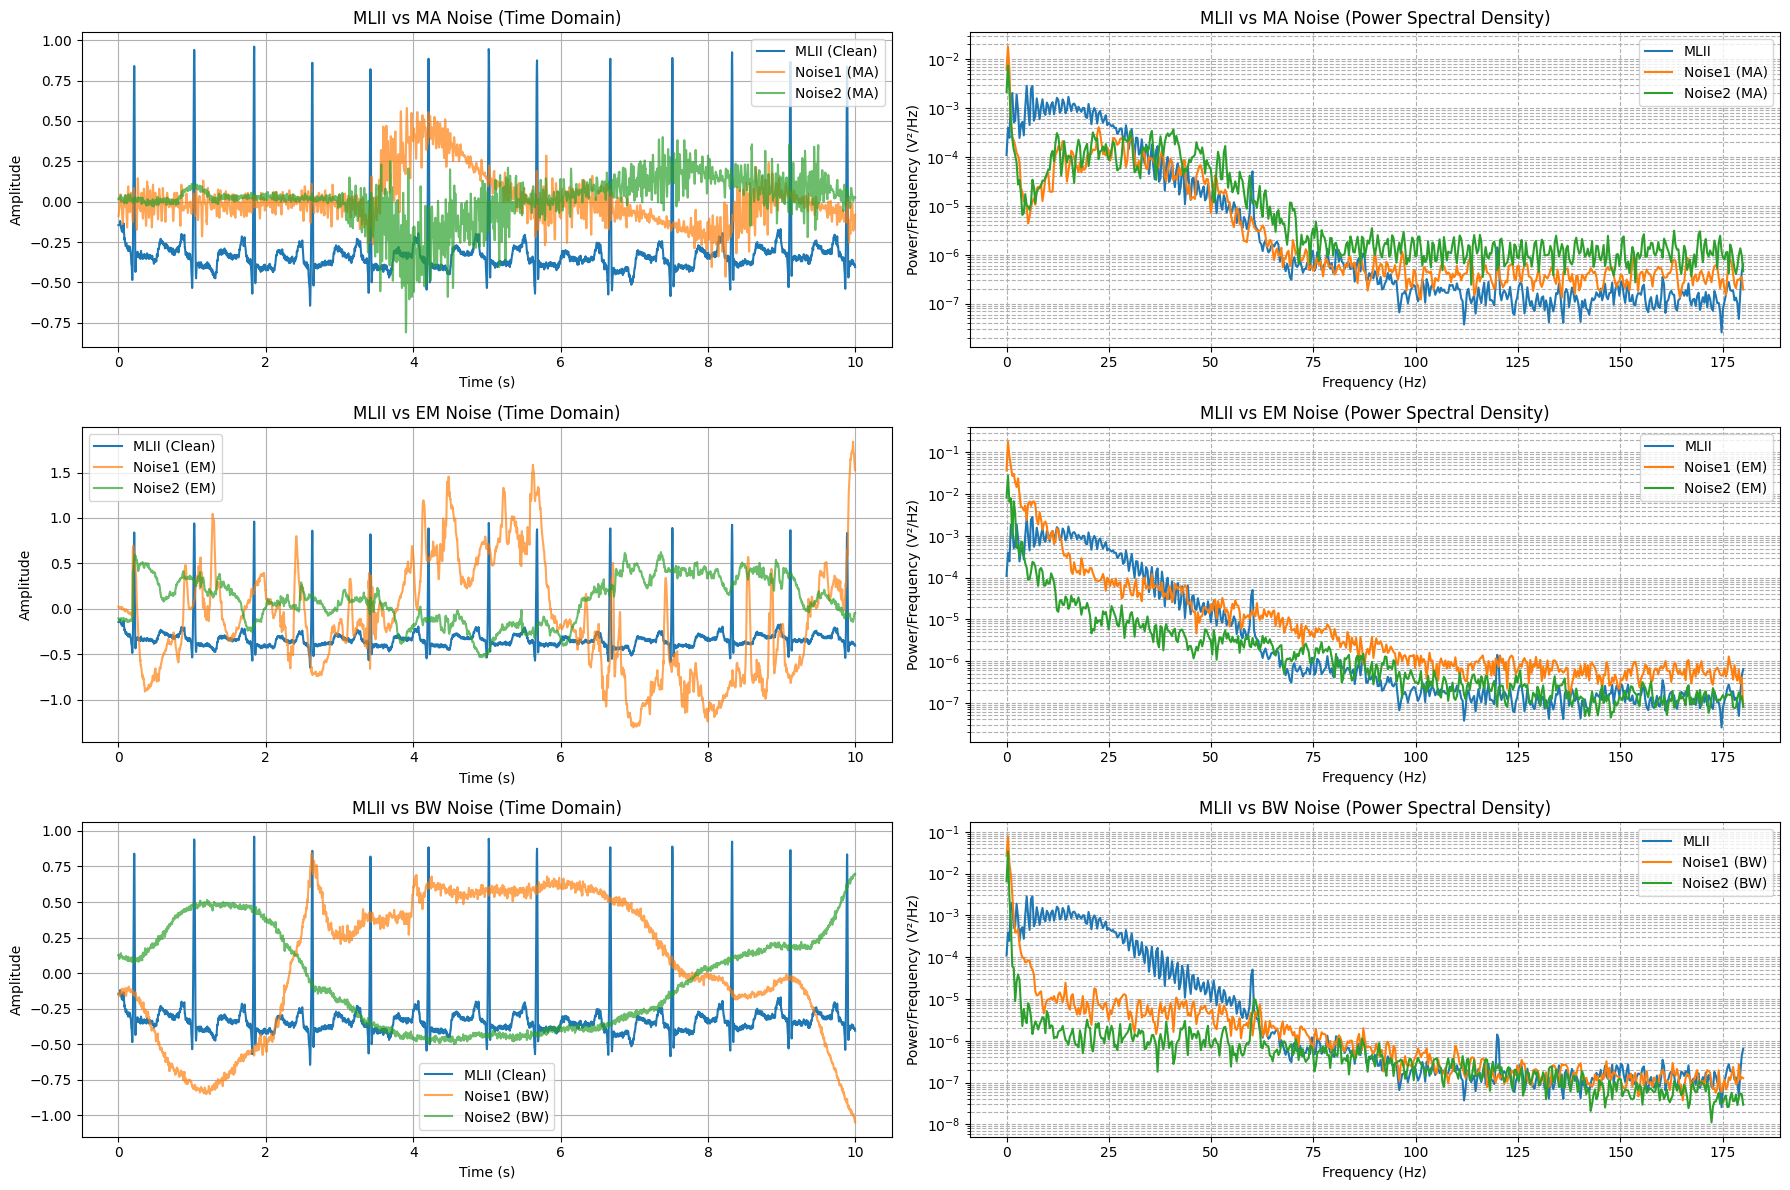

In [32]:

noise_types = ['ma', 'em', 'bw']
n_samples = len(ml_ii)

plt.figure(figsize=(18, 12))

for idx, n_type in enumerate(noise_types, 1):
    subset = nstdb[nstdb["type"] == n_type]
    noise1 = subset["noise1"].astype(float).values[:n_samples]
    noise2 = subset["noise2"].astype(float).values[:n_samples]

    freqs1, psd1 = welch(noise1, fs=fs, nperseg=1024)
    freqs2, psd2 = welch(noise2, fs=fs, nperseg=1024)


    plt.subplot(3, 2, 2*idx - 1)
    plt.plot(time_axis, ml_ii, label="MLII (Clean)")
    plt.plot(time_axis, noise1, label=f"Noise1 ({n_type.upper()})", alpha=0.7)
    plt.plot(time_axis, noise2, label=f"Noise2 ({n_type.upper()})", alpha=0.7)
    plt.title(f"MLII vs {n_type.upper()} Noise (Time Domain)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)


    plt.subplot(3, 2, 2*idx)
    plt.semilogy(freqs_ml, psd_ml, label="MLII")
    plt.semilogy(freqs1, psd1, label=f"Noise1 ({n_type.upper()})")
    plt.semilogy(freqs2, psd2, label=f"Noise2 ({n_type.upper()})")
    plt.title(f"MLII vs {n_type.upper()} Noise (Power Spectral Density)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (V²/Hz)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

plt.tight_layout()
plt.show()


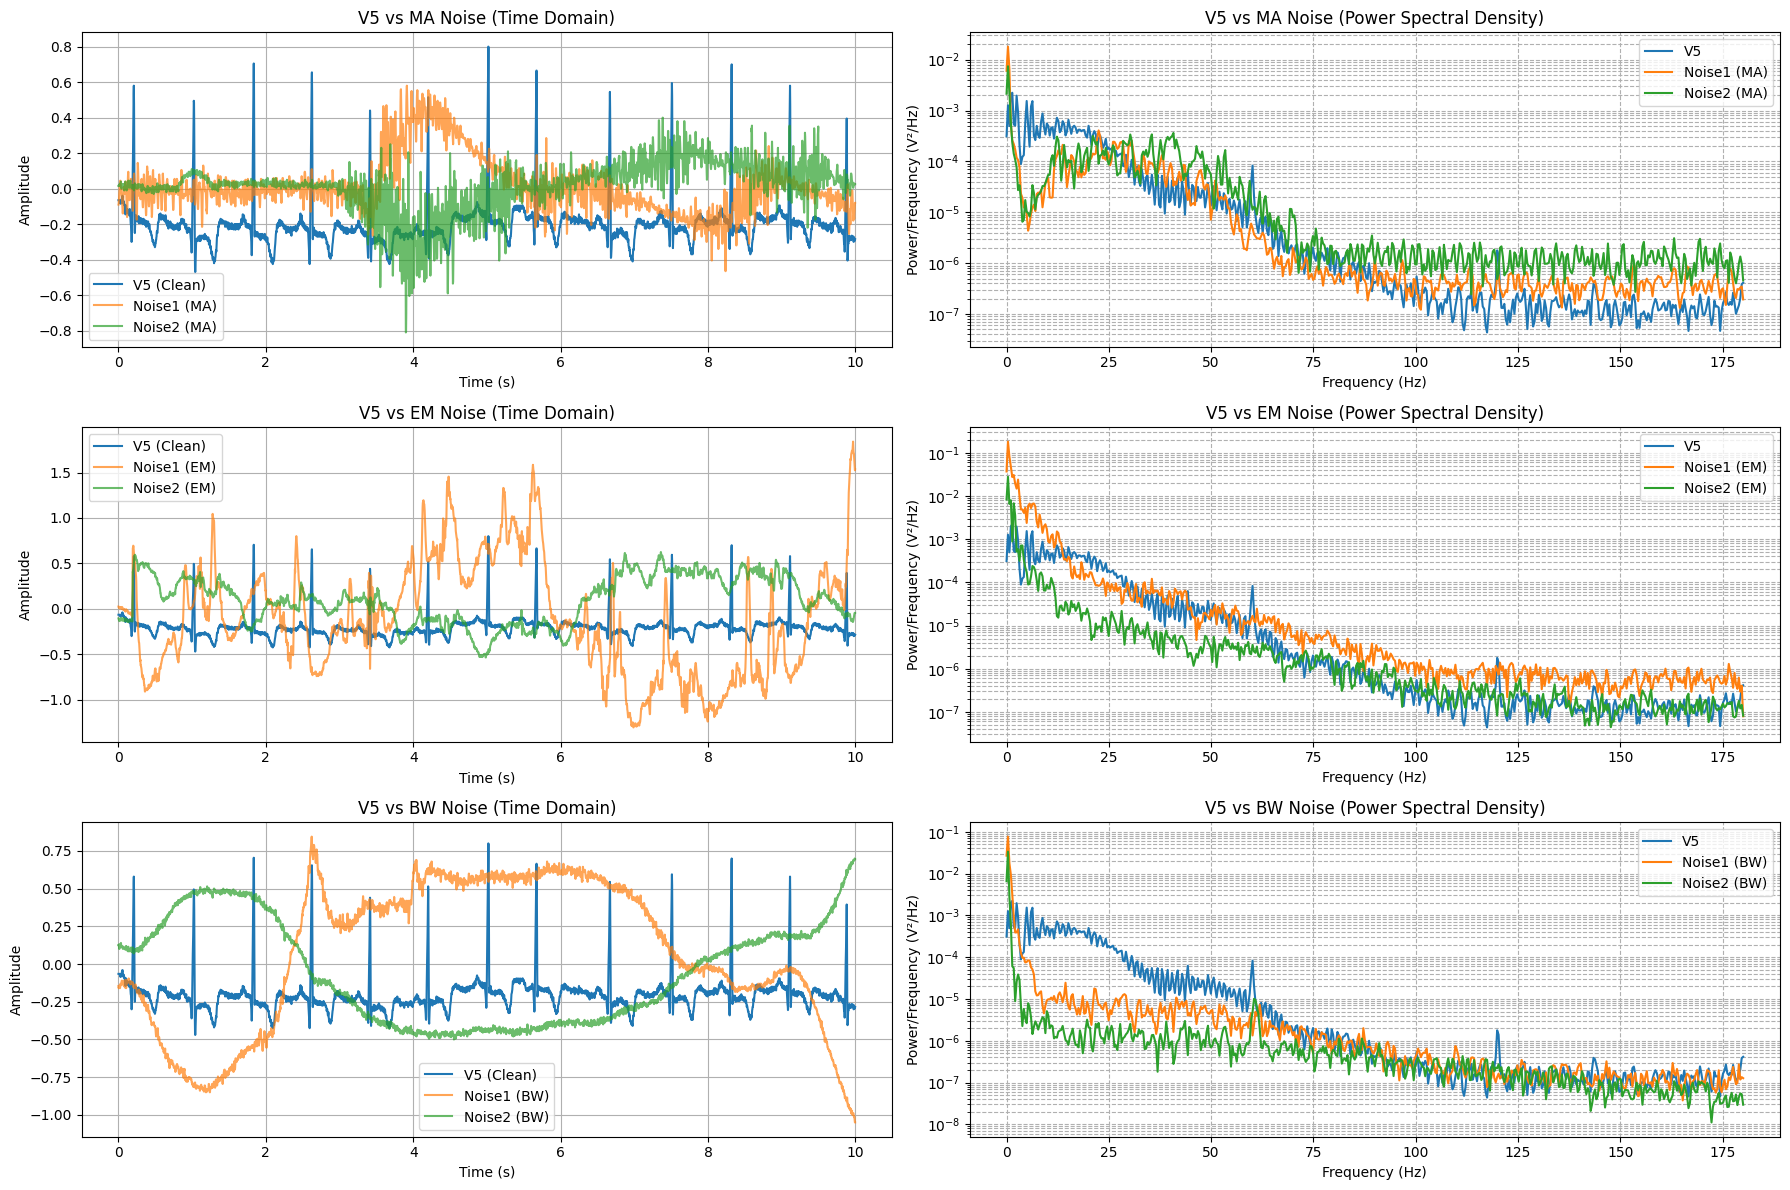

In [33]:
# Prepare figure for all 3 noise types applied to V5 instead of MLII
plt.figure(figsize=(18, 12))

for idx, n_type in enumerate(noise_types, 1):
    subset = nstdb[nstdb["type"] == n_type]
    noise1 = subset["noise1"].astype(float).values[:n_samples]
    noise2 = subset["noise2"].astype(float).values[:n_samples]

    freqs1, psd1 = welch(noise1, fs=fs, nperseg=1024)
    freqs2, psd2 = welch(noise2, fs=fs, nperseg=1024)
    freqs_v5, psd_v5 = welch(v5, fs=fs, nperseg=1024)

    # Time Domain Plot
    plt.subplot(3, 2, 2*idx - 1)
    plt.plot(time_axis, v5, label="V5 (Clean)")
    plt.plot(time_axis, noise1, label=f"Noise1 ({n_type.upper()})", alpha=0.7)
    plt.plot(time_axis, noise2, label=f"Noise2 ({n_type.upper()})", alpha=0.7)
    plt.title(f"V5 vs {n_type.upper()} Noise (Time Domain)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # Frequency Domain Plot
    plt.subplot(3, 2, 2*idx)
    plt.semilogy(freqs_v5, psd_v5, label="V5")
    plt.semilogy(freqs1, psd1, label=f"Noise1 ({n_type.upper()})")
    plt.semilogy(freqs2, psd2, label=f"Noise2 ({n_type.upper()})")
    plt.title(f"V5 vs {n_type.upper()} Noise (Power Spectral Density)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (V²/Hz)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--")

plt.tight_layout()
plt.show()

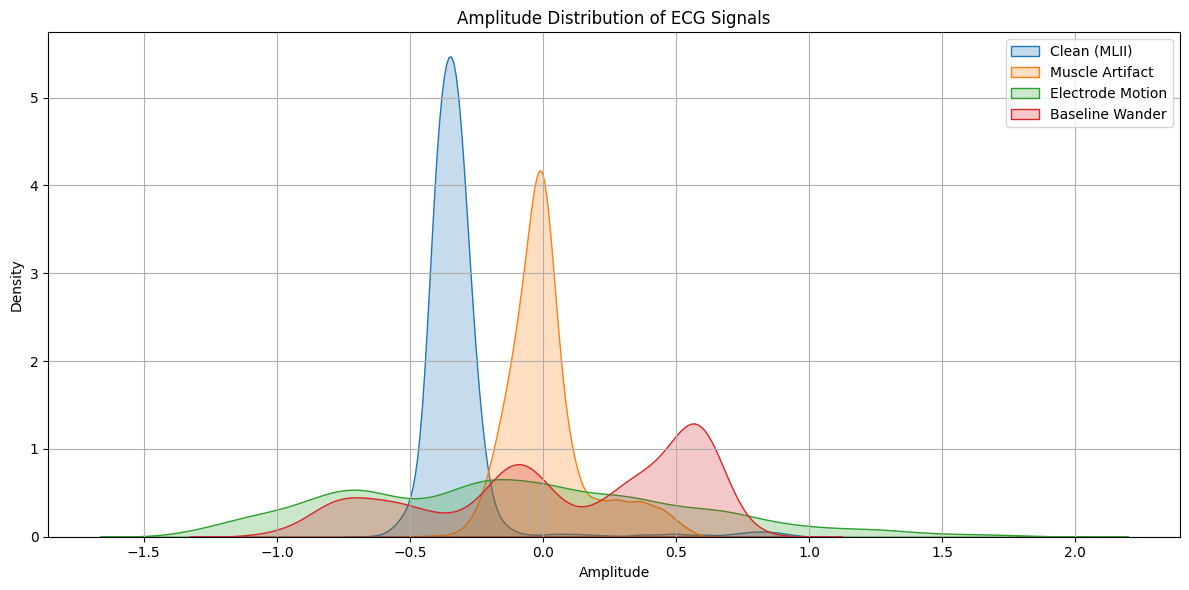

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
import re


def extract_valid_floats(series):
    return np.array([
        float(x) for x in series.astype(str)
        if re.fullmatch(r"-?\d+(\.\d+)?", x.strip())
    ])


signals = pd.read_csv("/content/mitbih_100_signals.csv")
nstdb = pd.read_csv("/content/nstdb.csv")


clean_signal = extract_valid_floats(signals["MLII"][:3600])
ma_signal = extract_valid_floats(nstdb[nstdb["type"] == "ma"]["noise1"][:3600])
em_signal = extract_valid_floats(nstdb[nstdb["type"] == "em"]["noise1"][:3600])
bw_signal = extract_valid_floats(nstdb[nstdb["type"] == "bw"]["noise1"][:3600])

# Amplitude KDE Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(clean_signal, label="Clean (MLII)", fill=True)
sns.kdeplot(ma_signal, label="Muscle Artifact", fill=True)
sns.kdeplot(em_signal, label="Electrode Motion", fill=True)
sns.kdeplot(bw_signal, label="Baseline Wander", fill=True)
plt.title("Amplitude Distribution of ECG Signals")
plt.xlabel("Amplitude")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



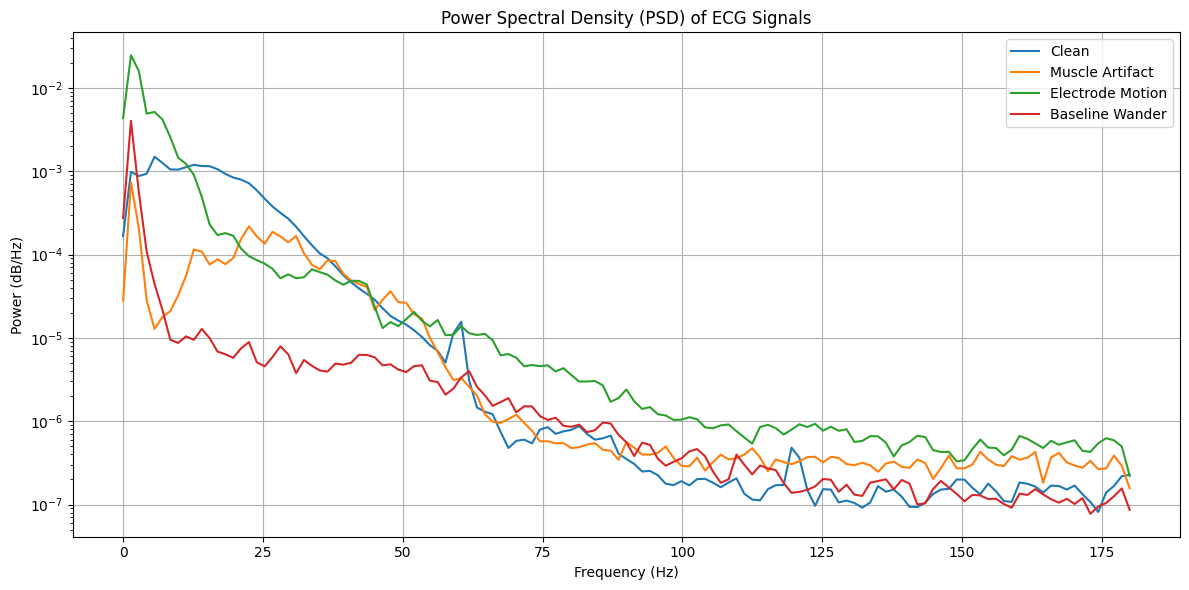

In [ ]:
# PSD Plot
fs = 360
plt.figure(figsize=(12, 6))
for signal, label in zip([clean_signal, ma_signal, em_signal, bw_signal],
                         ["Clean", "Muscle Artifact", "Electrode Motion", "Baseline Wander"]):
    f, Pxx = welch(signal, fs=fs)
    plt.semilogy(f, Pxx, label=label)

plt.title("Power Spectral Density (PSD) of ECG Signals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


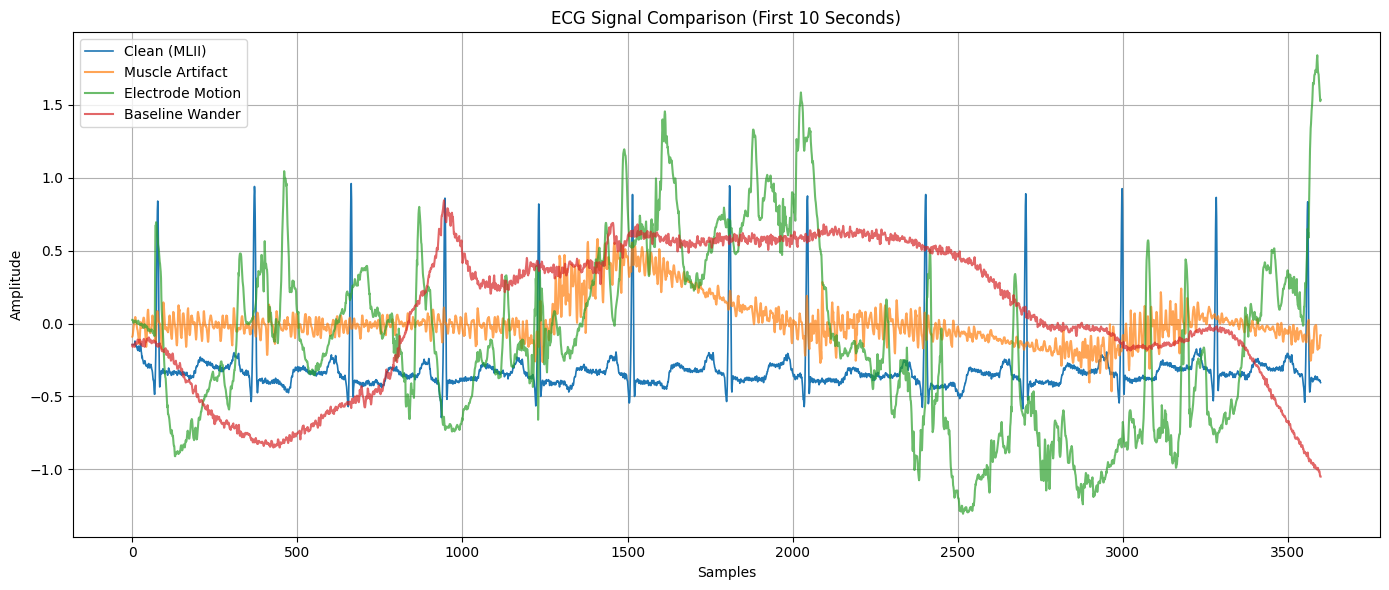

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import welch

# Sample clean signal from MIT-BIH (MLII lead)
clean_signal = signals["MLII"].values[:3600]


ma_signal = nstdb[nstdb["type"] == "ma"]["noise1"].values[:3600]
em_signal = nstdb[nstdb["type"] == "em"]["noise1"].values[:3600]
bw_signal = nstdb[nstdb["type"] == "bw"]["noise1"].values[:3600]


plt.figure(figsize=(14, 6))
plt.plot(clean_signal, label="Clean (MLII)", linewidth=1.2)
plt.plot(ma_signal, label="Muscle Artifact", alpha=0.7)
plt.plot(em_signal, label="Electrode Motion", alpha=0.7)
plt.plot(bw_signal, label="Baseline Wander", alpha=0.7)
plt.legend()
plt.title("ECG Signal Comparison (First 10 Seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
signals.head()